My kronecker regression is not passing tests and I can't figure out why. Gonna debug the test here. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division

import unittest
import numpy as np
import GPy

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
np.random.seed(0)
N1, N2 = 30, 20
X1 = np.random.randn(N1, 1)
X2 = np.random.randn(N2, 1)
X1.sort(0); X2.sort(0)
k1 = GPy.kern.RBF(1)  # + GPy.kern.White(1)
k2 = GPy.kern.RBF(1)  # + GPy.kern.White(1)
Y = np.random.randn(N1, N2)
Y = Y - Y.mean(0)
Y = Y / Y.std(0)
m = GPy.models.GPKroneckerGaussianRegression(X1, X2, Y, k1, k2)

# build the model the dumb way
assert (N1 * N2 < 1000), "too much data for standard GPs!"
yy, xx = np.meshgrid(X2, X1)
Xgrid = np.vstack((xx.flatten(order='F'), yy.flatten(order='F'))).T
kg = GPy.kern.RBF(1, active_dims=[0]) * GPy.kern.RBF(1, active_dims=[1])
mm = GPy.models.GPRegression(Xgrid, Y.reshape(-1, 1, order='F'), kernel=kg)

m.randomize()
mm[:] = m[:]
print m
print mm

print m.log_likelihood(), mm.log_likelihood()
assert np.allclose(m.log_likelihood(), mm.log_likelihood())
assert np.allclose(m.gradient, mm.gradient)
X1test = np.random.randn(100, 1)
X2test = np.random.randn(100, 1)
mean1, var1 = m.predict(X1test, X2test)
yy, xx = np.meshgrid(X2test, X1test)
Xgrid = np.vstack((xx.flatten(order='F'), yy.flatten(order='F'))).T
mean2, var2 = mm.predict(Xgrid)

assert np.allclose(mean1, mean2) 
assert np.allclose(var1, var2) 


Y (30, 20)
Y (30, 30)
Y (20, 20)
Y (30, 20)
Y (30, 30)
Y (20, 20)

Name : KGPR
Objective : 892.252976548
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  KGPR.                    |                value  |  constraints  |  priors
  rbf.variance             |   0.8468536004566632  |      +ve      |        
  rbf.lengthscale          |  0.09368631781879513  |      +ve      |        
  rbf_1.variance           |   0.8642490016685567  |      +ve      |        
  rbf_1.lengthscale        |   0.9865985656948761  |      +ve      |        
  Gaussian_noise.variance  |   0.8123004681155028  |      +ve      |        

Name : GP regression
Objective : 892.252975828
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  mul.rbf.variance         |   0.8468536004566632  |      +ve      |        
  mul.rbf.lengthscale      |  0.09368631781879513  

In [4]:
from itertools import permutations

In [5]:
for p in permutations(['x','y','z']):
    print p

('x', 'y', 'z')
('x', 'z', 'y')
('y', 'x', 'z')
('y', 'z', 'x')
('z', 'x', 'y')
('z', 'y', 'x')


In [93]:
def get_full_kron_row(Xs):
    Ks = []
    for i,X in enumerate(Xs):
        k = getattr(m, 'kern%d'%i)
        K = k.K(X)
        Ks.append(K)
    
    return reduce(np.kron, reversed(Ks))[0]

Extension Test ******************************
LL -1099.7367113886637 -1100.8769278230081
False


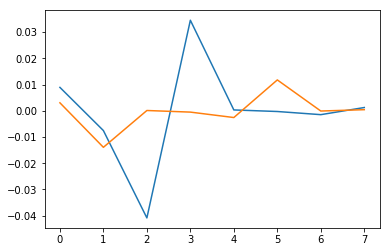

In [176]:
print 'Extension Test', '*'*30
# test with additional kernels
np.random.seed(0)
N1, N2, N3 = 50,4,3
X1 = np.random.randn(N1, 1)*3+1
X2 = np.random.randn(N2, 1)
X3 = np.random.randn(N3, 1)
X1.sort(0); X2.sort(0); X3.sort(0)


#k1 = GPy.kern.RBF(1, lengthscale=1)  # + GPy.kern.White(1)
#k2 = GPy.kern.RBF(1, lengthscale=1)  # + GPy.kern.White(1)
#k3 = GPy.kern.RBF(1, lengthscale=1)

k1 = GPy.kern.Linear(1)
k2 = GPy.kern.Linear(1)
k3 = GPy.kern.Linear(1)

Y = np.random.randn(N1, N2, N3)
#Y = Y - Y.mean((0,1))
#Y = Y / Y.std((0,1))

m = GPy.models.GPKroneckerGaussianRegression(X1, X2, Y, k1, k2,\
                            additional_Xs = [X3],\
                            additional_kerns = [k3])



# build the model the dumb way
assert (N1 * N2 * N3 < 1000), "too much data for standard GPs!"
zz, yy, xx = np.meshgrid(X3, X2, X1)


Xgrid = np.vstack((zz.flatten(order='F'), xx.flatten(order='F'), yy.flatten(order='F'))).T


kg = GPy.kern.Linear(1, active_dims=[0], ARD=True) * GPy.kern.Linear(1, active_dims=[1], ARD=True)\
* GPy.kern.Linear(1, active_dims=[2], ARD=True)
mm = GPy.models.GPRegression(Xgrid, Y.reshape(-1, 1, order='F'), kernel=kg)
# build the model the dumb way

m.randomize()
mm[:] = m[:]

print'LL', m.log_likelihood(), mm.log_likelihood()#, mmm.log_likelihood()
print np.allclose(m.log_likelihood(), mm.log_likelihood())
#assert np.allclose(m.log_likelihood(), mm.log_likelihood())
#assert np.allclose(m.gradient, mm.gradient)
X1test = np.random.randn(2, 1)*3+1
X2test = np.random.randn(2, 1)
X3test = np.random.randn(2, 1)

zz, yy, xx = np.meshgrid(X3test, X2test, X1test)

Xtest = np.vstack((zz.flatten(order='F'), xx.flatten(order='F'), yy.flatten(order='F'))).T

mean1, var1 = m.predict(X1test, X2test, additional_Xnews=[X3test])
mean2, var2 = mm.predict(Xtest)

plt.plot(mean1)

plt.plot(mean2)
#plt.yscale('log')
plt.show()
#print mean3[:5]
#assert np.allclose(mean1, mean2) 
#assert np.allclose(var1, var2) 
